In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import altair as alt
from math import sqrt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

In [5]:
#Reading input files to python dataframe
df_train = pd.read_csv('C:/Users/Hertz/OneDrive/Documents/CMPE255/Team Project/house-prices-advanced-regression-techniques/data from daniel/ames_raw.csv', encoding='utf-8')
df_test = pd.read_csv('C:/Users/Hertz/OneDrive/Documents/CMPE255/Team Project/house-prices-advanced-regression-techniques/data from daniel/test.csv', encoding='utf-8')

In [6]:
#Initial preprocessing on input file
df_train = df_train.loc[:, ~df_train.columns.str.contains('^Unnamed')]
df_train.columns = df_train.columns.str.replace(' ', '')
df_train.rename(columns={"Order": "Id","YearRemod/Add":"YearRemodAdd"},inplace='True')
print("Shape of train data :",df_train.shape)
print("Shape of test data :",df_test.shape)

Shape of train data : (2930, 82)
Shape of test data : (1459, 80)


In [7]:
#Incorporating crime data
year = {2006: '222.0', 
           2007: '265.7', 
           2008: '247.4', 
           2009: '219.6', 
           2010: '217.1'} 
df_train['Crime Rate'] = df_train['YrSold'].map(year)
df_test['Crime Rate'] = df_test['YrSold'].map(year)

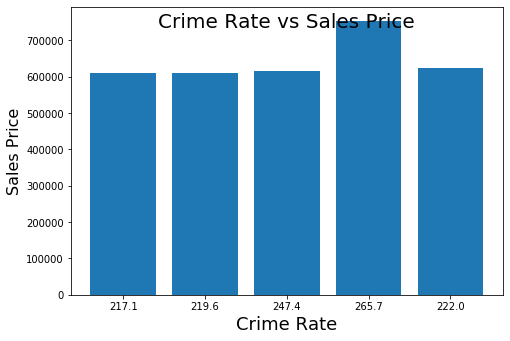

In [8]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_train['Crime Rate'],df_train['SalePrice'])
fig.suptitle('Crime Rate vs Sales Price', fontsize=20)
plt.xlabel('Crime Rate', fontsize=18)
plt.ylabel('Sales Price', fontsize=16)
plt.show()

In [9]:
df_train.shape

(2930, 83)

In [10]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2930.0,1.465500e+03,8.459625e+02,1.0,7.332500e+02,1465.5,2.197750e+03,2.930000e+03
PID,2930.0,7.144645e+08,1.887308e+08,526301100.0,5.284770e+08,535453620.0,9.071811e+08,1.007100e+09
MSSubClass,2930.0,5.738737e+01,4.263802e+01,20.0,2.000000e+01,50.0,7.000000e+01,1.900000e+02
LotFrontage,2440.0,6.922459e+01,2.336533e+01,21.0,5.800000e+01,68.0,8.000000e+01,3.130000e+02
LotArea,2930.0,1.014792e+04,7.880018e+03,1300.0,7.440250e+03,9436.5,1.155525e+04,2.152450e+05
OverallQual,2930.0,6.094881e+00,1.411026e+00,1.0,5.000000e+00,6.0,7.000000e+00,1.000000e+01
OverallCond,2930.0,5.563140e+00,1.111537e+00,1.0,5.000000e+00,5.0,6.000000e+00,9.000000e+00
YearBuilt,2930.0,1.971356e+03,3.024536e+01,1872.0,1.954000e+03,1973.0,2.001000e+03,2.010000e+03
YearRemodAdd,2930.0,1.984267e+03,2.086029e+01,1950.0,1.965000e+03,1993.0,2.004000e+03,2.010000e+03
MasVnrArea,2907.0,1.018968e+02,1.791126e+02,0.0,0.000000e+00,0.0,1.640000e+02,1.600000e+03


In [11]:
df_train.dtypes

Id                 int64
PID                int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
                  ...   
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Crime Rate        object
Length: 83, dtype: object

Skewness of Data: 1.7435000757376466


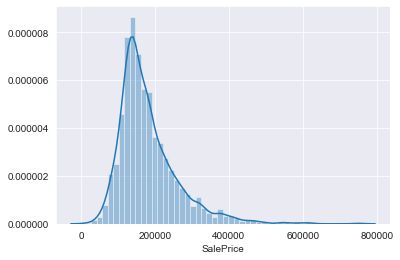

In [12]:
#Analyzing thw distribution of test variable  'SalePrice'
warnings.filterwarnings("ignore")
print("Skewness of Data:",format(df_train['SalePrice'].skew()))
sns.set_style('darkgrid')
sns.distplot(df_train['SalePrice'])

In [13]:
#Identifying the missing value columns in training data
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Missing Values in Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Missing Values in Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    return mis_val_table_ren_columns
missing_values_table(df_train)

Your selected dataframe has 83 columns.
There are 27 columns that have missing values.


,Missing Values,% of Missing Values in Total Values
PoolQC,2917,99.6
MiscFeature,2824,96.4
Alley,2732,93.2
Fence,2358,80.5
FireplaceQu,1422,48.5
LotFrontage,490,16.7
GarageCond,159,5.4
GarageQual,159,5.4
GarageFinish,159,5.4
GarageYrBlt,159,5.4


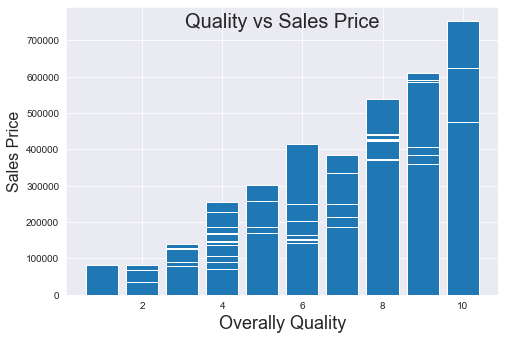

In [14]:
#Quality vs Sales Price
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_train['OverallQual'],df_train['SalePrice'])
fig.suptitle('Quality vs Sales Price', fontsize=20)
plt.xlabel('Overally Quality', fontsize=18)
plt.ylabel('Sales Price', fontsize=16)
plt.show()

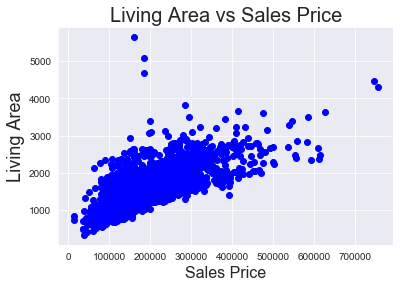

In [15]:
#Living Area vs Sales Price
plt.scatter(df_train['SalePrice'],df_train['GrLivArea'],c = 'blue')
plt.title('Living Area vs Sales Price', fontsize=20)
plt.ylabel('Living Area', fontsize=18)
plt.xlabel('Sales Price', fontsize=16)
plt.show()

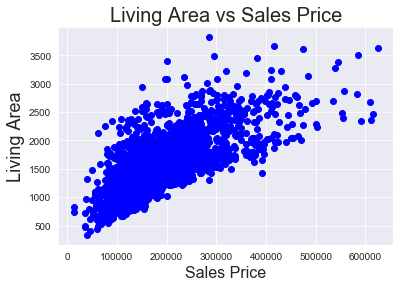

In [16]:
#Removing Outliers and Plotting
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index).reset_index(drop=True)
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']>700000)].index).reset_index(drop=True)
plt.scatter(df_train['SalePrice'],df_train['GrLivArea'],c = 'blue')
plt.title('Living Area vs Sales Price', fontsize=20)
plt.ylabel('Living Area', fontsize=18)
plt.xlabel('Sales Price', fontsize=16)
plt.show()

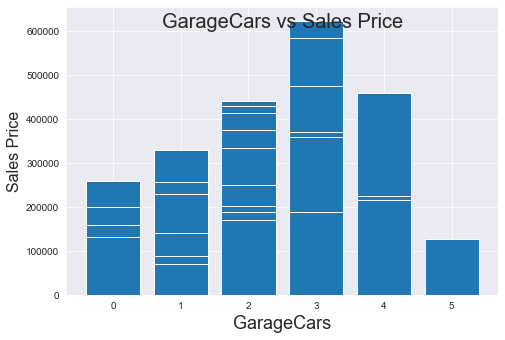

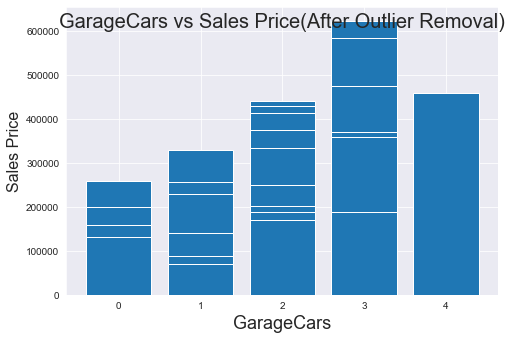

In [17]:
#Garage Cars Vs SalePrice
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_train['GarageCars'],df_train['SalePrice'])
fig.suptitle('GarageCars vs Sales Price', fontsize=20)
plt.xlabel('GarageCars', fontsize=18)
plt.ylabel('Sales Price', fontsize=16)
plt.show()
#Removing outliers and plotting 
df_train = df_train.drop(df_train[(df_train['GarageCars']>3) & (df_train['SalePrice']<300000)].index).reset_index(drop=True)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_train['GarageCars'],df_train['SalePrice'])
fig.suptitle('GarageCars vs Sales Price(After Outlier Removal)', fontsize=20)
plt.xlabel('GarageCars', fontsize=18)
plt.ylabel('Sales Price', fontsize=16)
plt.show()

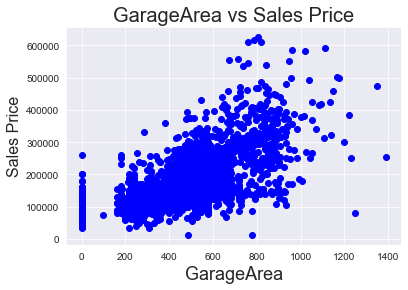

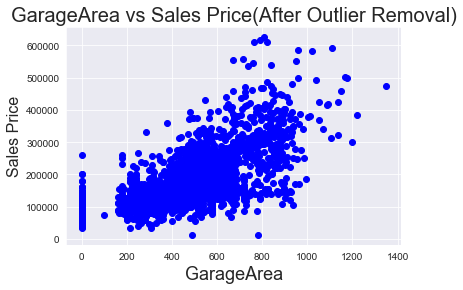

In [18]:
#GarageArea vs SalesPrice
plt.scatter(df_train['GarageArea'],df_train['SalePrice'],c = 'blue')
plt.title('GarageArea vs Sales Price', fontsize=20)
plt.xlabel('GarageArea', fontsize=18)
plt.ylabel('Sales Price', fontsize=16)
plt.show()
# Removing outliers and plotting 
df_train = df_train.drop(df_train[(df_train['GarageArea']>1000) & (df_train['SalePrice']<300000)].index).reset_index(drop=True)
plt.scatter(df_train['GarageArea'],df_train['SalePrice'],c = 'blue')
plt.title('GarageArea vs Sales Price(After Outlier Removal)', fontsize=20)
plt.xlabel('GarageArea', fontsize=18)
plt.ylabel('Sales Price', fontsize=16)
plt.show()

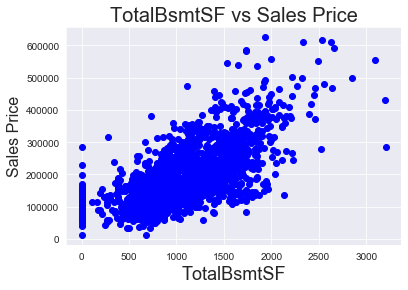

In [19]:
#Basement Area Vs SalePrice

plt.scatter(df_train['TotalBsmtSF'],df_train['SalePrice'],c = 'blue')
plt.title('TotalBsmtSF vs Sales Price', fontsize=20)
plt.xlabel('TotalBsmtSF', fontsize=18)
plt.ylabel('Sales Price', fontsize=16)
plt.show()

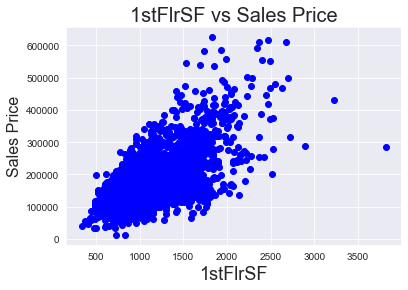

In [20]:
#1stFloorArea Vs SalePrice
plt.scatter(df_train['1stFlrSF'],df_train['SalePrice'],c = 'blue')
plt.title('1stFlrSF vs Sales Price', fontsize=20)
plt.xlabel('1stFlrSF', fontsize=18)
plt.ylabel('Sales Price', fontsize=16)
plt.show()

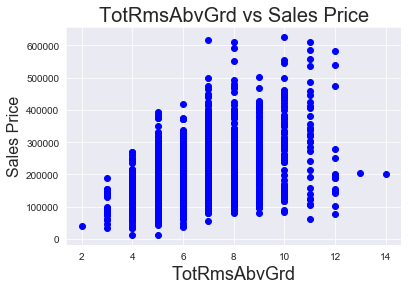

In [21]:
#Total Rooms Vs SalePrice
plt.scatter(df_train['TotRmsAbvGrd'],df_train['SalePrice'],c = 'blue')
plt.title('TotRmsAbvGrd vs Sales Price', fontsize=20)
plt.xlabel('TotRmsAbvGrd', fontsize=18)
plt.ylabel('Sales Price', fontsize=16)
plt.show()

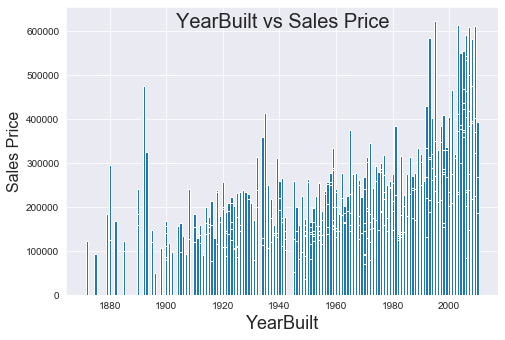

In [22]:
#YearBuilt Vs SalePrice
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_train['YearBuilt'],df_train['SalePrice'])
fig.suptitle('YearBuilt vs Sales Price', fontsize=20)
plt.xlabel('YearBuilt', fontsize=18)
plt.ylabel('Sales Price', fontsize=16)
plt.show()

In [23]:
#Reducing Skewness of test variable SalePrice
y = np.log(df_train.SalePrice).values

#Getting train and test shapes
df_train_shape = df_train.shape[0]
df_test_shape = df_test.shape[0]
test_ID=df_test['Id']

#Combining training and testing datasets.
df = pd.concat([df_train, df_test], axis=0, sort=False)
df.drop(['SalePrice','PID','Id'], axis=1, inplace=True)
df_shape=df.shape[0]

In [24]:
#Handling Missing Values

col1 = ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','GarageYrBlt', 'GarageArea','GarageCars','MasVnrArea')
col2 = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','Fence','PoolQC','MiscFeature','Alley','FireplaceQu','Fence','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
col3 = ['Utilities','Exterior1st','Exterior2nd','SaleType','Functional','Electrical','KitchenQual', 'GarageFinish', 'GarageQual', 'GarageCond','MasVnrType']

#Filling null values in col1 with 0
for col in col1:
    df[col] = df[col].fillna(0)

#Filling null values in col2 with None
for col in col2:
    df[col] = df[col].fillna('None')

#Filling null values in col3 with mode of that column
for col in col3:
    df[col] = df[col].fillna(df[col].mode()[0])

#Filling null values in below columns with median of that column
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

#For rows where all neighborhood has null lotFrontage,fill 0
df['LotFrontage'] = df['LotFrontage'].fillna(0)

#Filling null values in below columns with mode of that column
df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))


In [25]:
missing_values_table(df)

Your selected dataframe has 80 columns.
There are 0 columns that have missing values.


,Missing Values,% of Missing Values in Total Values


In [26]:
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [27]:
# Attributes having maximum correlation to sales price

corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

SalePrice        1.000000
OverallQual      0.805541
GrLivArea        0.720571
GarageCars       0.666318
GarageArea       0.663508
TotalBsmtSF      0.659867
1stFlrSF         0.645029
YearBuilt        0.565761
FullBath         0.544381
YearRemodAdd     0.538697
GarageYrBlt      0.533860
MasVnrArea       0.515530
TotRmsAbvGrd     0.498451
Fireplaces       0.473914
BsmtFinSF1       0.445877
LotFrontage      0.364988
WoodDeckSF       0.328148
OpenPorchSF      0.325190
BsmtFullBath     0.281838
HalfBath         0.280746
LotArea          0.273543
2ndFlrSF         0.253124
BsmtUnfSF        0.186013
BedroomAbvGr     0.135407
ScreenPorch      0.115248
PoolArea         0.041604
MoSold           0.035970
3SsnPorch        0.033731
BsmtFinSF2       0.007213
MiscVal         -0.018423
YrSold          -0.029827
Id              -0.032263
LowQualFinSF    -0.037620
BsmtHalfBath    -0.047881
MSSubClass      -0.089362
OverallCond     -0.105099
EnclosedPorch   -0.131069
KitchenAbvGr    -0.132908
PID         

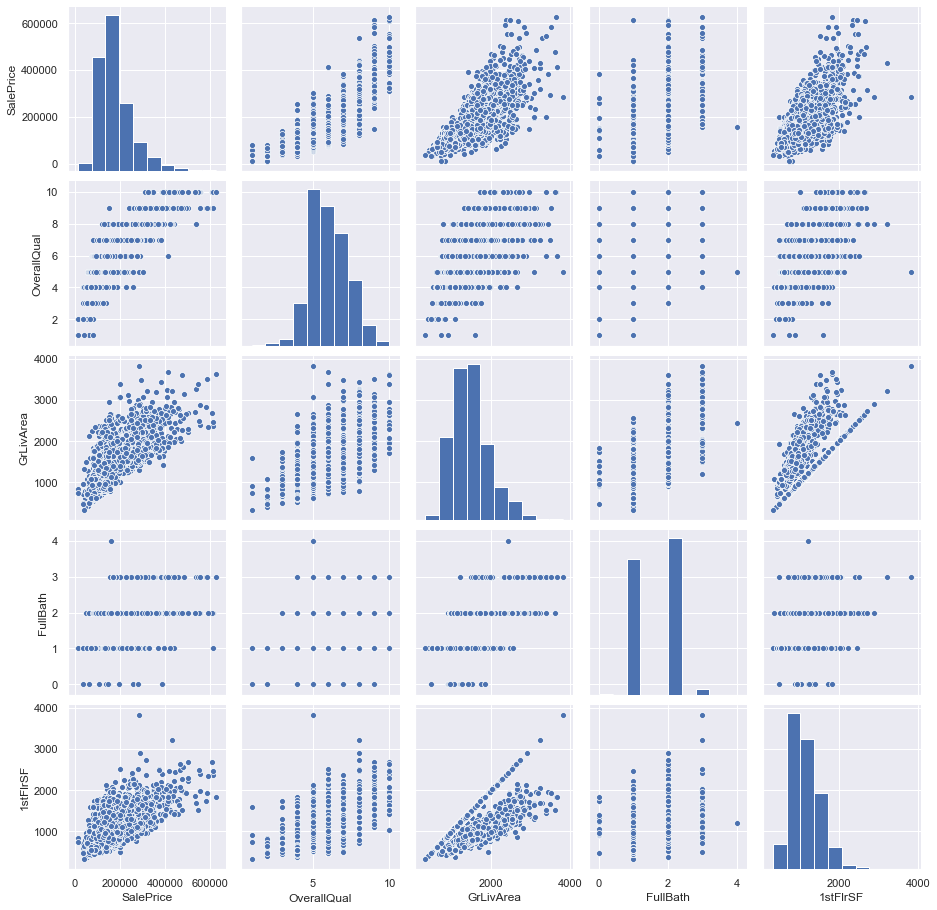

In [28]:
#Paiplot of most correlated features
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'FullBath','1stFlrSF']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

In [29]:
#Recreate train and test dataset from all data
df = pd.get_dummies(df) 
df_train = df[:df_train_shape]
df_test = df[df_train_shape:df_shape]
print("Shape of train data:",df_train.shape)
print("Shape of test data:",df_test.shape)
X=df_train.values

#Split the train data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

Shape of train data: (2902, 322)
Shape of test data: (1459, 322)


In [30]:
##Model Evaluation
n_folds = 10
def model_evaluate(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    print ("R^2 is: {}\nRMSE is: {}".format(model.score(X_test, y_test),rmse.mean()))
    

R2 score of Linear Regression: 0.9397805444623856


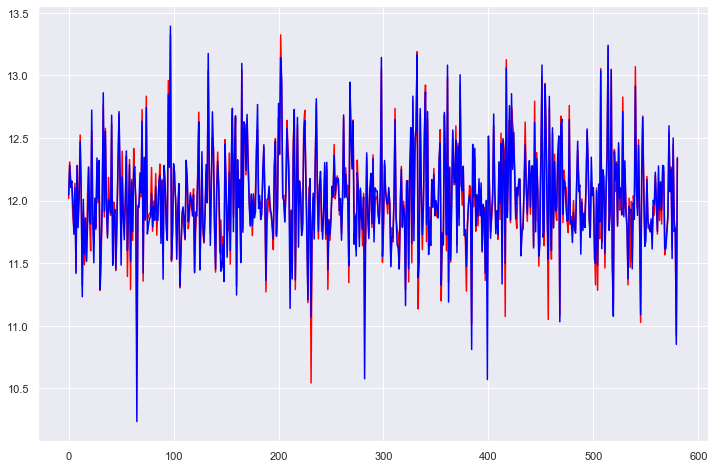

R2 score of RandomForest Regression: 0.9836754766599503
RMSE score of RandomForestRegression: 0.1139642362448514


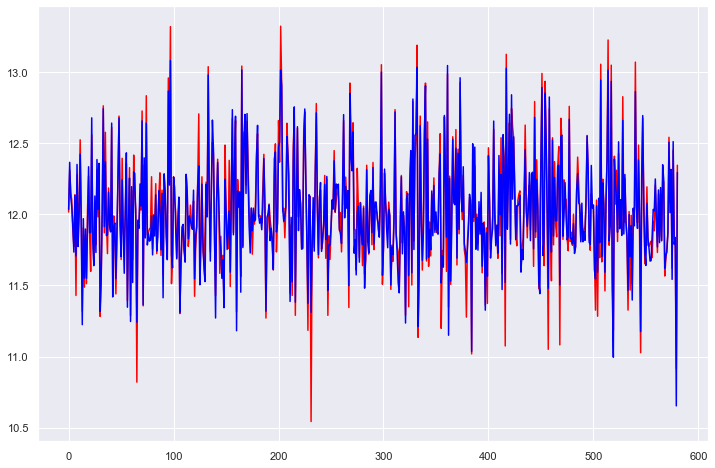

In [31]:
##LinearRegression

linearRegression = linear_model.LinearRegression()
linearRegModel=linearRegression.fit(X_train,y_train)
print("R2 score of Linear Regression:",linearRegModel.score(X_train, y_train))

# Predict new result
y_pred = linearRegModel.predict(X_test)

# Plot y_test vs y_pred
plt.figure(figsize=(12,8))
plt.plot(y_test, color='red')
plt.plot(y_pred, color='blue')
plt.show()

##RandomForestRegressor
rndmForestRegressorModel = RandomForestRegressor(n_estimators=300, random_state=0)
rndmForestRegressorModel.fit(X_train,y_train)
print("R2 score of RandomForest Regression:",rndmForestRegressorModel.score(X_train, y_train))

# Predict new result
y_pred_rfr = rndmForestRegressorModel.predict(X_test)
rms=sqrt(mean_squared_error(y_test,y_pred_rfr))
print("RMSE score of RandomForestRegression:",rms)

# Plot y_test vs y_pred
plt.figure(figsize=(12,8))
plt.plot(y_test, color='red')
plt.plot(y_pred_rfr, color='blue')
plt.show()

R2 score of Random Forest Regression with PCA: 0.9812021120193218
R2 score of Linear Regression with PCA: 0.8868501068341901


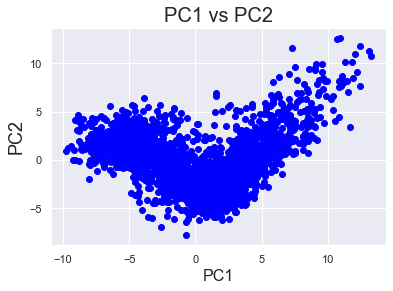

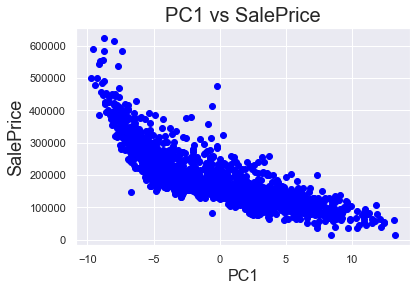

Principal components relations with features:      MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
PC1    0.007274    -0.059671 -0.034014    -0.184168     0.050184  -0.190604   
PC2    0.106226    -0.060395 -0.062072     0.051677    -0.068746   0.017412   

     YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  \
PC1     -0.155997   -0.100609   -0.086574    0.003482  ...   
PC2      0.086723   -0.011945   -0.107288   -0.106245  ...   

     SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
PC1               0.024656              0.014884              0.003814   
PC2               0.030009              0.007414             -0.008192   

     SaleCondition_Normal  SaleCondition_Partial  Crime Rate_217.1  \
PC1              0.029697              -0.089799          0.008503   
PC2             -0.078570               0.097031         -0.010208   

     Crime Rate_219.6  Crime Rate_222.0  Crime Rate_247.4  Crime Rate_265.7  
PC1          0.00

In [32]:
##Dimension Reduction using PCA

##PCA with 35 components

##Standardizing the data
sc = StandardScaler() 
X_train_sc = sc.fit_transform(X_train) 
X_test_sc = sc.transform(X_test) 
data_scaled = pd.DataFrame(X_train_sc,columns = df_train.columns)

##Applying PCA
pca = PCA(n_components = 35)  
X_train_pca = pca.fit_transform(X_train_sc) 
X_test_pca = pca.transform(X_test_sc)
explained_variance = pca.explained_variance_ratio_ 

##RandomForestRegressorr Regression+PCA
RandmForestRegressor_afterPCA = RandomForestRegressor(n_estimators=300, random_state=0)
RandmForestRegressorModel_afterPCA=RandmForestRegressor_afterPCA.fit(X_train_pca,y_train)
print("R2 score of Random Forest Regression with PCA:",RandmForestRegressorModel_afterPCA.score(X_train_pca, y_train))

##Linear Regression+PCA
linearRegression_afterPCA = linear_model.LinearRegression()
linearRegModel_PCA=linearRegression_afterPCA.fit(X_train_pca,y_train)
print("R2 score of Linear Regression with PCA:",linearRegModel_PCA.score(X_train_pca, y_train))


###PCA with 2 components
pca_2cmpnts = PCA(n_components = 2) 
X_train_pca_2cmpnts = pca_2cmpnts.fit_transform(X_train_sc) 
X_test_pca_2cmpnts = pca_2cmpnts.transform(X_test_sc) 
pca_df = pd.DataFrame(data = X_train_pca_2cmpnts
             , columns = ['PC1','PC2'])
pca_df['target']=np.exp(y_train)
plt.scatter(pca_df['PC1'],pca_df['PC2'],c = 'blue')
plt.title('PC1 vs PC2', fontsize=20)
plt.ylabel('PC2', fontsize=18)
plt.xlabel('PC1', fontsize=16)
plt.show()

plt.scatter(pca_df['PC1'],pca_df['target'],c = 'blue')
plt.title('PC1 vs SalePrice', fontsize=20)
plt.ylabel('SalePrice', fontsize=18)
plt.xlabel('PC1', fontsize=16)
plt.show()

# Principal components relations with features:
print ("Principal components relations with features:",pd.DataFrame(pca_2cmpnts.components_,columns=data_scaled.columns,index = ['PC1','PC2']))



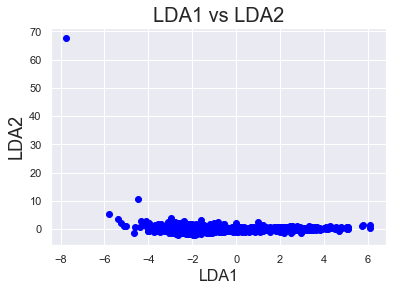

R2 Score of Linear Regression with LDA 0.7963047380926751


In [33]:
##Implement LinearDiscriminantAnalysis

lda = LDA(n_components = 2)
y_train_lda = np.array(y_train).astype(int)
X_train_lda = lda.fit_transform(X_train_sc,y_train_lda)
X_test_lda = lda.transform(X_test_sc)
lda_df = pd.DataFrame(data = X_train_lda
             , columns = ['LDA1','LDA2'])

plt.scatter(lda_df['LDA1'],lda_df['LDA2'],c = 'blue')
plt.title('LDA1 vs LDA2', fontsize=20)
plt.ylabel('LDA2', fontsize=18)
plt.xlabel('LDA1', fontsize=16)
plt.show()

# Train Linear Regression with LDA

linearRegression_afterLDA = linear_model.LinearRegression()
linearRegModel_LDA=linearRegression_afterLDA.fit(X_train_lda,y_train)
print("R2 Score of Linear Regression with LDA",linearRegModel_LDA.score(X_train_lda, y_train))

In [34]:
##Support Vector Regression Models

svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

svr_rbf_model=svr_rbf.fit(X_train_sc,y_train)
print("R2 score of Support Vector Regression -RBF model:",svr_rbf_model.score(X_train_sc, y_train))

svr_poly_model=svr_poly.fit(X_train_sc,y_train)
print("R2 score of Support Vector Regression -POLY model:",svr_poly_model.score(X_train_sc, y_train))




R2 score of Support Vector Regression -RBF model: 0.9474259199577544
R2 score of Support Vector Regression -POLY model: 0.9701927005059965


In [35]:
#Kaggle Submission

sub = pd.DataFrame()
sub['Id'] = test_ID
print(sub.shape)
sub['SalePrice'] = np.exp(rndmForestRegressorModel.predict(df_test))
#sub['SalePrice'] = np.exp(linearRegModel.predict(df_test))
#sub.to_csv('C:/MyWorld/Sneha/Studies/255-Data Mining/Project/submission.csv',index=False)



(1459, 1)


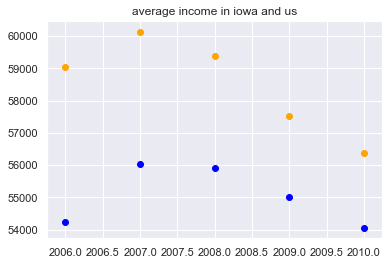

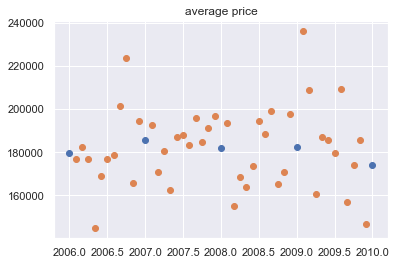

In [41]:
#df_train = pd.read_csv('C:/Users/Hertz/OneDrive/Documents/CMPE255/Team Project/house-prices-advanced-regression-techniques/train_merge_with_schools.csv', encoding='utf-8')
#https://www.macrotrends.net/cities/us/ia/ames/crime-rate-statistics
crime = np.array([[2006, 279.78], [2007,387.43], [2008,313.13], [2009,309.59], [2010,306.14]])
#stock_market = np.array([[2006, 1300], [2007,1400], [2008,1400], [2009,900], [2010,1100]])
income_iowa = np.array([[2006, 54224], [2007, 56048], [2008,55902], [2009,55025], [2010,54038]])
income_us = np.array([[2006, 59051], [2007, 60135], [2008,59382], [2009,57519], [2010,56388]])
#https://www.deptofnumbers.com/income/iowa/
df_income_iowa = pd.DataFrame(income_iowa)
df_income_us = pd.DataFrame(income_us)
#df_stock_market = pd.DataFrame(stock_market)
df_crime = pd.DataFrame(crime)
np_average_price = df_train[['Yr Sold', 'SalePrice', 'Mo Sold']].to_numpy()

def average(year):
    count = 0
    price = 0
    for x in range(np_average_price.shape[0]):
     if np_average_price[x,0]==year:
        count = count+1
        price = price + np_average_price[x,1]
    return price/count
def average_with_mo(year, month):
    count = 0
    price = 0
    for x in range(np_average_price.shape[0]):
     if np_average_price[x,0]==year and np_average_price[x,2]==month:
        count = count+1
        price = price + np_average_price[x,1]
    return price/count
#average_with_mo(2006, 1)
def average_all(start_year, end_year):
    array = [];
    for x in range(start_year, end_year):
        for mo in range(1,12):
            a = average_with_mo(x, mo)
            array.append([x+mo/12,a])
    return array

year_and_mo = average_all(2006, 2010)
df_year_and_mo = pd.DataFrame(year_and_mo)

average_price = [[2006, average(2006)], [2007, average(2007)], [2008, average(2008)], [2009, average(2009)], [2010, average(2010)]]
#print(average_price)
#plt.scatter(df_train['YrSold'], df_train['SalePrice'],c='blue')


fig1 = plt.figure()
plt.title('average income in iowa and us')
plt.scatter(df_income_iowa[0], df_income_iowa[1], c='blue')
plt.scatter(df_income_us[0], df_income_us[1],c='orange')
fig3 = plt.figure()
plt.title('average price')
df_average = pd.DataFrame(average_price)
plt.scatter(df_average[0], df_average[1])
plt.scatter(df_year_and_mo[0],df_year_and_mo[1] )


In [42]:
new_train = df_train.drop(columns=['Id', 'PID'])
df_train_drop_col = new_train.loc[:,df_train.isnull().sum()/len(df_train.index)<0.7]
df_train_drop_col_row = df_train_drop_col.dropna()
corr = df_train_drop_col_row.corr()
corr.sort_values(['SalePrice'], ascending=False, inplace = True)
high_corr = corr.SalePrice
array = []
for x in range(1,5):
    array.append(high_corr.index[x])
array

['Overall Qual', 'Garage Area', 'Garage Cars', 'Gr Liv Area']

In [43]:
df = df_train_drop_col_row
new_numeric = df._get_numeric_data()
#print(new_numeric)

#print(y_train)
def attempt():
    Y = new_numeric['SalePrice']
    X = new_numeric.drop(columns='SalePrice')
    X = df_train_drop_col_row[array]
    x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.2)
    
    regressor = LinearRegression()  
    regressor.fit(x_train, y_train)
    regressor.predict(x_test)
    value = regressor.score(x_test,y_test)
    return value

value = 0;
for x in range(0,20):
    value = value + attempt()
    print(attempt())
print("Average: " + str(value/20))

0.693950584685888
0.7388917913349202
0.8048068127557001
0.6091102796195816
0.6460434907992938
0.7641708488633422
0.7675671608488392
0.7214424820649732
0.8389558281062186
0.7935228519760508
0.6798944020949662
0.7874773773586252
0.7907841993081918
0.6803129842654045
0.740014395179883
0.7471726158138252
0.6545612342195456
0.7981220987984173
0.6121832223046038
0.7842035055488746
Average: 0.7034332516381079


In [44]:
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

SalePrice          1.000000
Overall Qual       0.797704
Garage Area        0.699514
Garage Cars        0.699442
Gr Liv Area        0.654331
Total Bsmt SF      0.603378
1st Flr SF         0.592833
Garage Yr Blt      0.550646
Year Remod/Add     0.549381
Mas Vnr Area       0.538648
Year Built         0.536760
TotRms AbvGrd      0.514666
Full Bath          0.488747
BsmtFin SF 1       0.389177
Lot Area           0.358170
Open Porch SF      0.316706
Bsmt Full Bath     0.294544
Lot Frontage       0.291239
Wood Deck SF       0.273065
Half Bath          0.204871
2nd Flr SF         0.182518
Bsmt Unf SF        0.172027
Screen Porch       0.125860
Fireplaces         0.093622
Bedroom AbvGr      0.076772
Mo Sold            0.049294
3Ssn Porch         0.027373
Mitchell           0.020246
Yr Sold            0.004603
BsmtFin SF 2       0.003731
Pool Area         -0.011750
Edwards           -0.024843
Misc Val          -0.024863
Low Qual Fin SF   -0.025246
Meeker            -0.027964
Northwood         -0

In [45]:
def attempt():
    Y = new_numeric['SalePrice']
    X = new_numeric.drop(columns='SalePrice')
    X = df_train_drop_col_row[['Overall Qual', 'Garage Area', 'Garage Cars', 'Gr Liv Area']]
    x_train, x_test,y_train,y_test = train_test_split(X,Y,test_size =0.2)
    
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(x_train,y_train)
    decision_tree.predict(x_test)
    value = decision_tree.score(x_test,y_test)
    return value

value = 0;
for x in range(0,19):
    value = value + attempt()
print(value/20) 

0.004347826086956521
